Customer Subscription to Term Deposit

In [1135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix
from lightgbm import LGBMClassifier
import seaborn as sns


In [1136]:
Data_File_Path = "term-deposit-marketing-2020.csv"
data_file = pd.read_csv(Data_File_Path)
print(data_file)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign    y

In [1137]:
data = data_file.copy()

Split target column from data.

In [1138]:
Yraw = data["y"]  # Target variable

# Separate features (X)
Xraw = data.drop(columns=["y"])  # Drop target column from the dataset
print(Xraw)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign  
0 

In [1139]:
print("Features (X) shape:", Xraw.shape)
print("Target (y) shape:", Yraw.shape)

Features (X) shape: (40000, 13)
Target (y) shape: (40000,)


In [1140]:
data.nunique()

age            70
job            12
marital         3
education       4
default         2
balance      6849
housing         2
loan            2
contact         3
day            31
month          11
duration     1535
campaign       48
y               2
dtype: int64

In [1141]:
data["job"].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

Convert yes/no in y column into 1/0.

In [1142]:
Yraw = Yraw.str.lower()
Y = Yraw.map({"no": 0, "yes": 1})

Check distribution according to yes/no or 1/0 classes in data.

In [1143]:
print(Y.value_counts())

y
0    37104
1     2896
Name: count, dtype: int64


In [1144]:
print(Y)

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64


Convert all binary column values into numerical.

In [1145]:
# Convert binary columns to 1/0 in X (modify the original data)
Xraw['default'] = Xraw['default'].str.lower()
Xraw['housing'] = Xraw['housing'].str.lower()
Xraw['loan'] = Xraw['loan'].str.lower()
Xraw['default'] = Xraw['default'].map({'no': 0, 'yes': 1})
Xraw['housing'] = Xraw['housing'].map({'no': 0, 'yes': 1})
Xraw['loan'] = Xraw['loan'].map({'no': 0, 'yes': 1})

# Check the result
print(Xraw[['default', 'housing', 'loan']].head())

   default  housing  loan
0        0        1     0
1        0        1     0
2        0        1     1
3        0        1     0
4        0        0     0


Convert Education column data into numerical by using label encoding technique.

In [1146]:

Xraw['education'] = Xraw['education'].str.lower()
education_mapping = {
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
    'unknown': 0  # or any other number to represent 'unknown'
}

# Apply the mapping to the `education` column
Xraw['education'] = Xraw['education'].map(education_mapping)

# Check the result
print(Xraw[['education']].head())

   education
0          3
1          2
2          2
3          0
4          0


Convert Month column data into numerical by using label encoding technique.

In [1147]:
Xraw['month'] = Xraw['month'].str.lower()

# Create the mapping dictionary for months
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# Apply the map function after converting to lowercase
Xraw['month'] = Xraw['month'].map(month_mapping)

# Check the result
print(Xraw[['month']].head())

   month
0      5
1      5
2      5
3      5
4      5


Convert rest of the categorical columns data into numerical using One Hot Encoding

In [1148]:
# List of categorical columns to encode
categorical_columns = ['job', 'marital', 'contact']
Xraw = pd.get_dummies(Xraw, columns=categorical_columns, drop_first=True)

In [1149]:
Xraw = Xraw.astype(int)
print(Xraw.head())

   age  education  default  balance  housing  loan  day  month  duration  \
0   58          3        0     2143        1     0    5      5       261   
1   44          2        0       29        1     0    5      5       151   
2   33          2        0        2        1     1    5      5        76   
3   47          0        0     1506        1     0    5      5        92   
4   33          0        0        1        0     0    5      5       198   

   campaign  ...  job_self-employed  job_services  job_student  \
0         1  ...                  0             0            0   
1         1  ...                  0             0            0   
2         1  ...                  0             0            0   
3         1  ...                  0             0            0   
4         1  ...                  0             0            0   

   job_technician  job_unemployed  job_unknown  marital_married  \
0               0               0            0                1   
1           

Null value check

In [1150]:
Xraw.isnull().sum()

age                  0
education            0
default              0
balance              0
housing              0
loan                 0
day                  0
month                0
duration             0
campaign             0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
job_unknown          0
marital_married      0
marital_single       0
contact_telephone    0
contact_unknown      0
dtype: int64

No Null value

In [1151]:
Xraw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
education,40000.0,2.046850,0.766694,0.0,2.0,2.0,3.0,3.0
default,40000.0,0.020225,0.140771,0.0,0.0,0.0,0.0,1.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
housing,40000.0,0.600775,0.489745,0.0,0.0,1.0,1.0,1.0
loan,40000.0,0.173250,0.378468,0.0,0.0,0.0,0.0,1.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
month,40000.0,6.009800,2.301095,1.0,5.0,6.0,7.0,12.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [1152]:
print(Xraw.shape)

(40000, 25)


Merging target back with data to draw correlation matrix

In [1153]:
df = pd.concat([Xraw, Y], axis=1)
print(df)

       age  education  default  balance  housing  loan  day  month  duration  \
0       58          3        0     2143        1     0    5      5       261   
1       44          2        0       29        1     0    5      5       151   
2       33          2        0        2        1     1    5      5        76   
3       47          0        0     1506        1     0    5      5        92   
4       33          0        0        1        0     0    5      5       198   
...    ...        ...      ...      ...      ...   ...  ...    ...       ...   
39995   53          3        0      395        0     0    3      6       107   
39996   30          3        0     3340        0     0    3      6       238   
39997   54          2        0      200        0     0    3      6       170   
39998   34          3        0     1047        0     0    3      6       342   
39999   38          2        0     1442        1     0    3      6       113   

       campaign  ...  job_services  job

Correlation Matrix

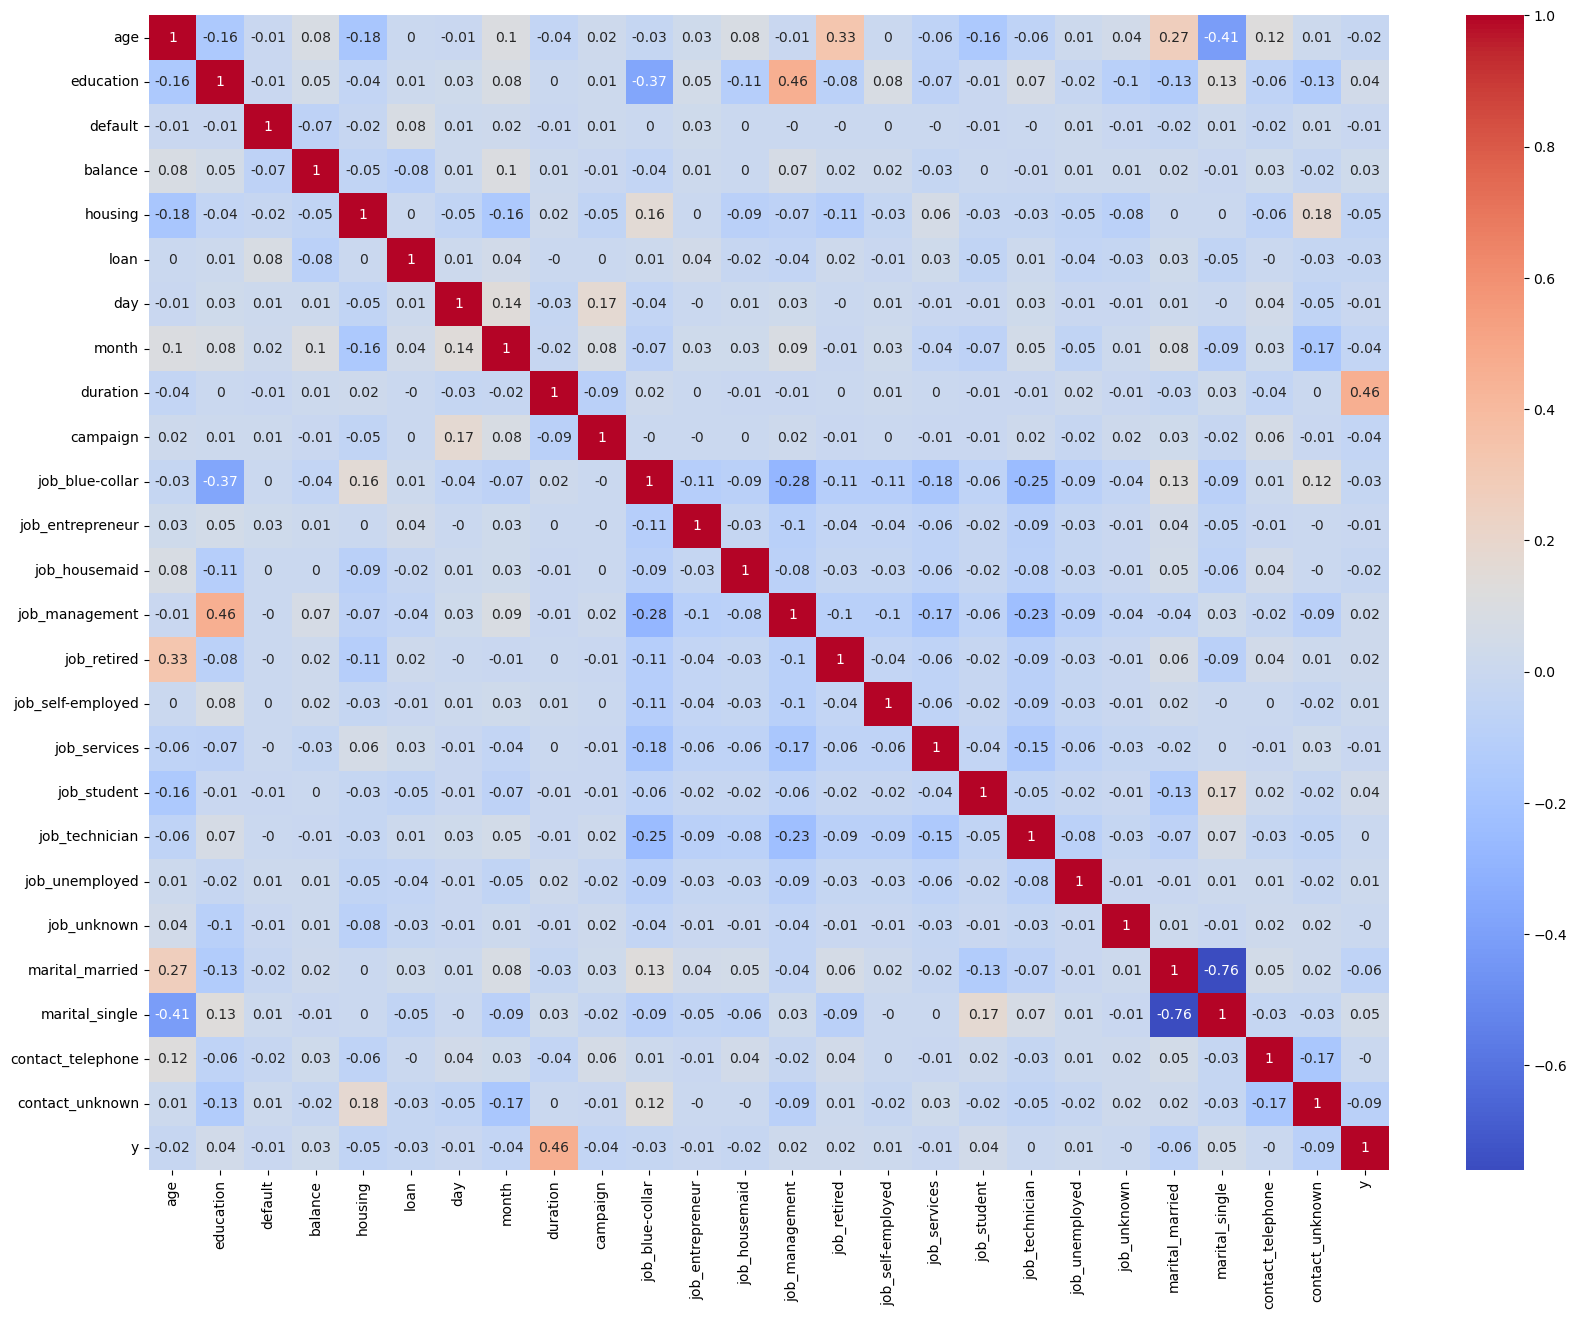

In [1154]:
Corr_Matrix = round(df.corr(),2)
fig, ax=plt.subplots(figsize=(20,15))
sns.heatmap(Corr_Matrix, annot=True, ax=ax, cmap='coolwarm');

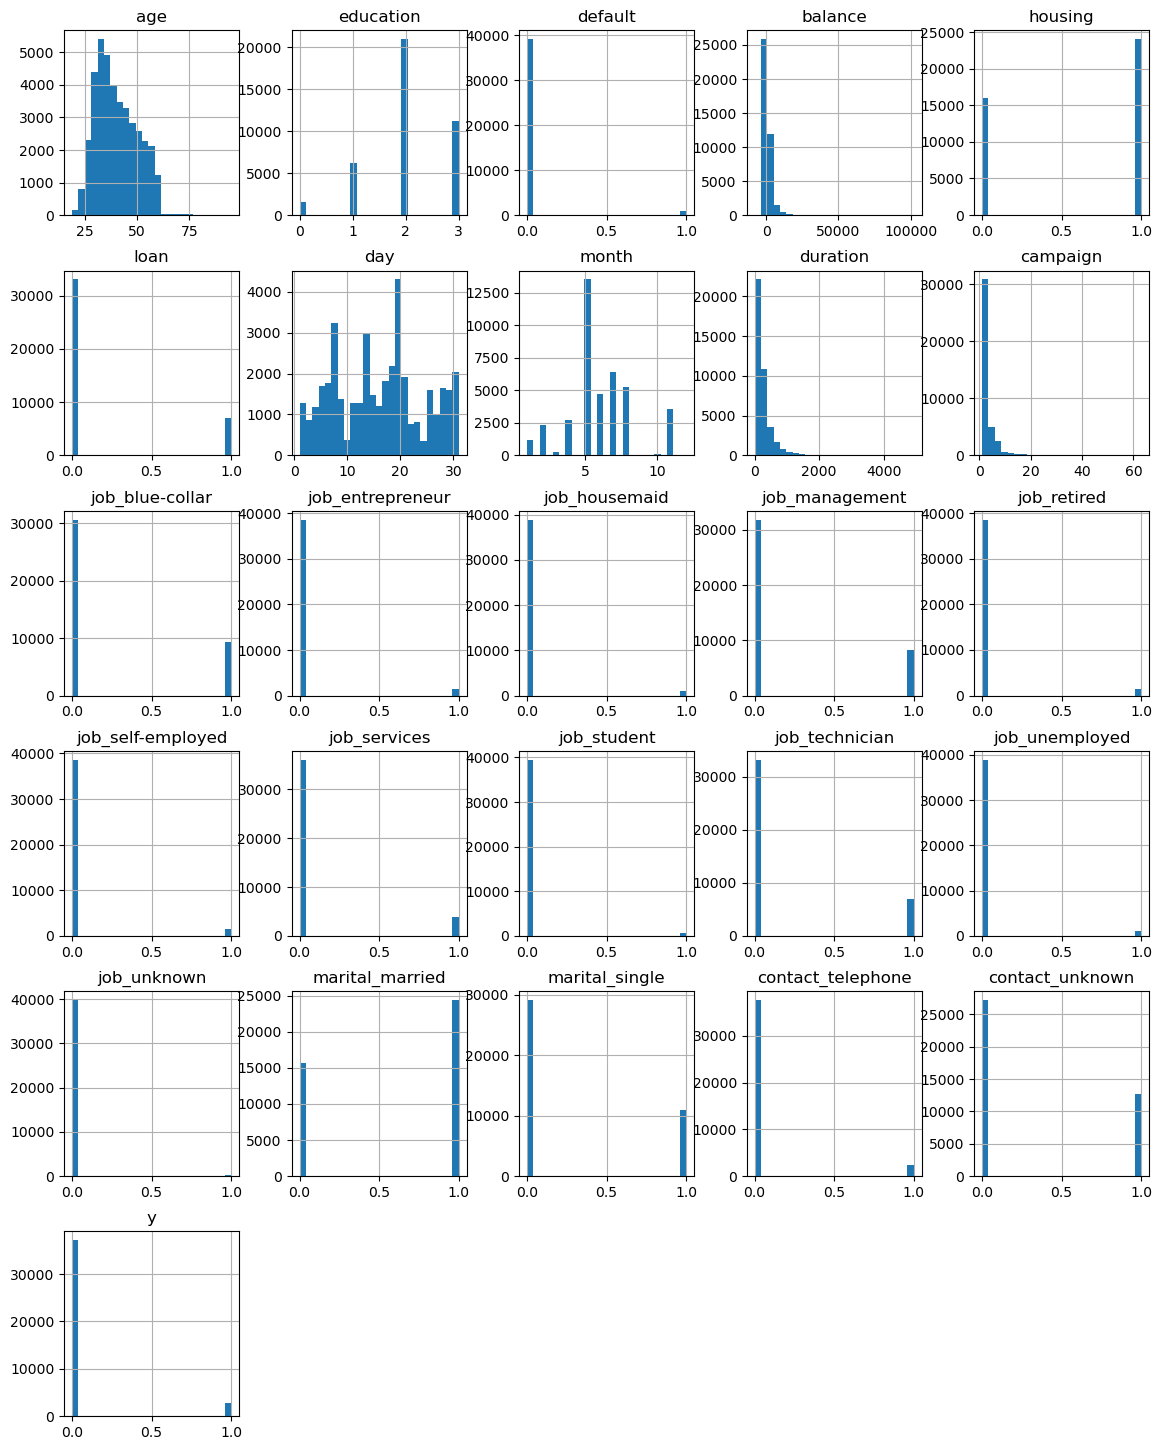

In [1155]:
#Histograms of all features.
df.hist(bins=25, figsize=(14,18))
plt.show()

Columns to drop. Less correlated columns with target and high correlated columns between each other have been dropped.

In [ ]:
yf = df["y"]  # Target variable
features_to_drop = [
    'default',          # Almost zero correlation with y
    'day',              # Very weak correlation with y
    'marital_single',   # High correlation (-0.76) with marital_married (keeping marital_married)
    'job_unknown',      # Very weak correlation with y
    'job_unemployed',      # Very weak correlation with y
    'job_technician',      # Very weak correlation with y
    'job_services',      # Very weak correlation with y
    'job_entrepreneur',      # Very weak correlation with y
    'job_self-employed',      # Very weak correlation with y
    'contact_telephone',  # Weak correlation with y
    'y'
]

# Drop the selected features from the dataset
X = df.drop(columns=features_to_drop)



In [1157]:
print(X.shape)

(40000, 15)


In [1158]:
print(yf.shape)

(40000,)


Data split into test and train dataset

In [1159]:
# Split dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, yf, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)

# Convert back to DataFrame (optional)
X = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Step 4: Transform test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)


Oversample miniority class by using SMOTE

In [1160]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_train_resampled = smote.fit_resample(X, y_train)
print(X_resampled.shape)
print(y_train_resampled.shape)

(59360, 15)
(59360,)


Oversampling miniority class by repeating miniority class instances

In [1161]:

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y_train)

Logistic reggression model

In [1162]:
# # Initialize Logistic Regression with class weight adjustment
# model = LogisticRegression(random_state=42) # class_weight='balanced', 

# # Train the model
# model.fit(X_resampled, y_resampled)

Random forest model

In [1163]:
# Train Random Forest with class weight balancing
# model = RandomForestClassifier(class_weight='balanced', random_state=42)
# model.fit(X_resampled, y_train_resampled)
# model.fit(X_train, y_train)

Light GBM model

In [1164]:
# light gbm
# model = LGBMClassifier(random_state=42)
# model.fit(X_resampled, y_train_resampled)
# y_pred = model.predict(X_test_scaled)


XGBoost model

In [1165]:


# Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.7, 0.8, 1.0]
# }

model = XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), random_state=42)

# random_model = RandomizedSearchCV(xgbmodel, param_distributions=param_grid, 
#                                 n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1)
# random_model.fit(X_resampled, y_train_resampled)
# # Best model
# model = random_model.best_estimator_
# Evaluate

model.fit(X_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)


Predict probabilities to apply different thresholds.

In [1166]:
# Get predicted probabilities from model
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

# Try different thresholds and find the best one
threshold = 0.48
y_pred_custom = (y_probs >= threshold).astype(int)


Confusion Matrix

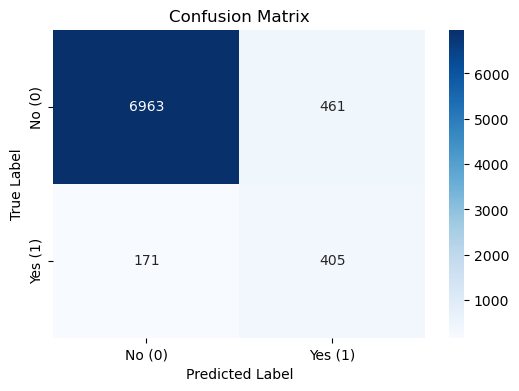

In [1167]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No (0)", "Yes (1)"], yticklabels=["No (0)", "Yes (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy

In [1168]:
# Predict on test set
# y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_custom)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9210


In [1169]:
# print(X_resampled.shape)
print(X_test_scaled.shape)
# print(y_train_resampled.shape)
print(y_pred.shape)
print(y_test.shape)

(8000, 15)
(8000,)
(8000,)


F1 score

In [1170]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred_custom)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5617


5 fold cross validation.

In [1171]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y_train, cv=5, scoring='accuracy')

# Print average accuracy across 5 folds
print(f"5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f}")

5-Fold Cross-Validation Accuracy: 0.9279


Area under ROC-AUC

ROC-AUC Score: 0.9318


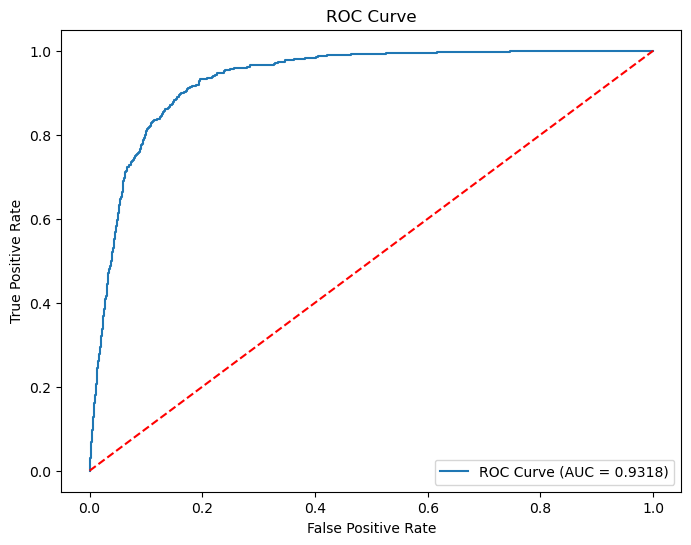

In [1172]:
# Get probability scores for positive class
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()